Action points

* prepare train, valid data
* train several models with hyperport, log them to MLFlow and select the best one
* apply trained model to new periods
* monitor quality, data drift with Grafana


# Load data



In [2]:
import os


root_data_dir = '/srv/data/dataset/e_commerce'

print(os.listdir(root_data_dir))

['olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_products_dataset.csv', 'product_category_name_translation.csv', 'olist_sellers_dataset.csv', 'olist_customers_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_geolocation_dataset.csv']


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def filter_df(df, value_col):
    percentile_95 = df[value_col].quantile(0.95)
    percentile_05 = df[value_col].quantile(0.05)
    df_filtered = df[(df[value_col] <= percentile_95) & (df[value_col] >= percentile_05)]
    
    return df_filtered

def filter_df_by_date(df, dt_col, date_filter):
    if date_filter is not None:
        start_date = date_filter['start_date']
        end_date = date_filter['end_date']
        df = df[(df[dt_col] >= start_date) & (df[dt_col] <= end_date)]
    return df

def plot_timeseries(df, value, dt_col = 'purchase_dt', filter_outliers=False, date_filter=None):
    grouped_df = df.groupby(dt_col)[value].sum().reset_index()

    if filter_outliers:
        grouped_df = filter_df(grouped_df, 'price')
    if date_filter is not None:
        start_date = date_filter['start_date']
        end_date = date_filter['end_date']
        grouped_df = grouped_df[(grouped_df[dt_col] >= start_date) & (grouped_df[dt_col] <= end_date)]
    
    # Plot the line chart
    plt.figure(figsize=(10, 6))
    plt.plot(grouped_df[dt_col], grouped_df[value], marker='o')
    plt.xlabel(dt_col)
    plt.ylabel(value)
    plt.title('Revenue by Date')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

orders_dataset = pd.read_csv(os.path.join(root_data_dir, 'olist_orders_dataset.csv'))

orders_dataset['purchase_dt'] = pd.to_datetime(orders_dataset['order_purchase_timestamp'].apply(lambda x: x[:10]))

print(orders_dataset.shape[0])
orders_dataset.head()

99441


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_dt
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-13


In [4]:
orders_items_dataset = pd.read_csv(os.path.join(root_data_dir, 'olist_order_items_dataset.csv'))

print(orders_items_dataset.shape[0])
orders_items_dataset.head(3)

112650


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [5]:
pd.read_csv(os.path.join(root_data_dir, 'olist_customers_dataset.csv'), nrows=1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [6]:
pd.read_csv(os.path.join(root_data_dir, 'olist_products_dataset.csv'), nrows=1)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40,287,1,225,16,10,14


In [7]:
pd.read_csv(os.path.join(root_data_dir, 'product_category_name_translation.csv'), nrows=1)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty


In [8]:
pd.read_csv(os.path.join(root_data_dir, 'olist_sellers_dataset.csv'), nrows=1)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP


In [9]:
pd.read_csv(os.path.join(root_data_dir, 'olist_geolocation_dataset.csv'), nrows=1)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP


In [18]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

# preparing orders
orders_filtered_df = filter_df_by_date(
    orders_dataset, dt_col='order_purchase_timestamp',
    date_filter={'start_date': '2017-02-01', 'end_date':'2017-12-01'}
)

orders_filtered_df['delivery_time'] = (
    (
        pd.to_datetime(orders_filtered_df['order_delivered_customer_date']) -
        pd.to_datetime(orders_filtered_df['order_purchase_timestamp'])
    )
    .apply(lambda td: td.total_seconds() / (60*60))
)

percentile_95 = orders_filtered_df['delivery_time'].quantile(0.95)
orders_filtered_df = orders_filtered_df[orders_filtered_df['delivery_time'] <= percentile_95]
#

sellers_df = pd.read_csv(os.path.join(root_data_dir, 'olist_sellers_dataset.csv'))
customers_df = pd.read_csv(os.path.join(root_data_dir, 'olist_customers_dataset.csv'))
locations_df = pd.read_csv(os.path.join(root_data_dir, 'olist_geolocation_dataset.csv'))
# because of zip_code_prefix != zip_code
locations_df = (
    locations_df
    .groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']]
    .mean()
    .reset_index()
)

delivery_df = (
    orders_filtered_df[['order_id', 'purchase_dt', 'customer_id', 'order_delivered_customer_date', 'order_purchase_timestamp', 'delivery_time']]
    .merge(orders_items_dataset[['order_id', 'price', 'seller_id', 'product_id']], on='order_id')
    .merge(sellers_df[['seller_id', 'seller_zip_code_prefix']], on='seller_id')
    .merge(customers_df[['customer_id', 'customer_zip_code_prefix']], on='customer_id')
    .merge(
        locations_df[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']]
            .rename(columns={'geolocation_zip_code_prefix': 'customer_zip_code_prefix', 'geolocation_lat': 'dest_lat', 'geolocation_lng': 'dest_lng'}),
        on='customer_zip_code_prefix'
    )
    .merge(
        locations_df[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']]
            .rename(columns={'geolocation_zip_code_prefix': 'seller_zip_code_prefix', 'geolocation_lat': 'start_lat', 'geolocation_lng': 'start_lng'}),
        on='seller_zip_code_prefix'
    )
)
delivery_df['delivery_distance_km'] = delivery_df.apply(lambda row: haversine(row['start_lat'], row['start_lng'], row['dest_lat'], row['dest_lng']), axis=1)

delivery_df.head()

/tmp/ipykernel_19/2068370604.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_filtered_df['delivery_time'] = (


,order_id,purchase_dt,customer_id,order_delivered_customer_date,order_purchase_timestamp,delivery_time,price,seller_id,product_id,seller_zip_code_prefix,customer_zip_code_prefix,dest_lat,dest_lng,start_lat,start_lng,delivery_distance_km
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,9ef432eb6251297304e76186b10a928d,2017-10-10 21:25:13,2017-10-02 10:56:33,202.477778,29.99,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,9350,3149,-23.576983,-46.587161,-23.680729,-46.444238,18.576110
1,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18,f88197465ea7920adcdbec7375364d82,2017-12-02 00:28:42,2017-11-18 19:28:06,317.010000,45.00,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,31842,59296,-5.774190,-35.271143,-19.837682,-43.924053,1822.226336
2,a4591c265e18cb1dcee52889e2d8acc3,2017-07-09,503740e9ca751ccdda7ba28e9ab8f608,2017-07-26 10:57:55,2017-07-09 21:57:05,397.013889,147.90,8581055ce74af1daba164fdbd55a40de,060cb19345d90064d1015407193c233d,7112,86320,-23.553522,-50.549924,-23.468704,-46.516142,411.394362
3,6514b8ad8028c9f2cc2374ded245783f,2017-05-16,9bdf08b4b3b52b5526ff42d37d47f222,2017-05-26 12:55:51,2017-05-16 13:10:30,239.755833,59.99,16090f2ca825584b5a147ab24aa30c86,4520766ec412348b8d4caa5e8a18c464,12940,26525,-22.805707,-43.423079,-23.114731,-46.552881,322.277082
4,e69bfb5eb88e0ed6a785585b27e16dbf,2017-07-29,31ad1d1b63eb9962463f764d4e6e0c9d,2017-08-16 17:14:30,2017-07-29 11:55:02,437.324444,149.99,7c67e1448b00f6e969d365cea6b010ab,9a78fb9862b10749a117f7fc3c31f051,8577,18075,-23.474030,-47.467397,-23.486111,-46.366721,112.263374


In [19]:
print(orders_filtered_df.shape[0])
orders_filtered_df.head()

35304


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_dt,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-02,202.477778
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-18,317.010000
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00,2017-07-09,397.013889
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07 00:00:00,2017-05-16,239.755833
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23 00:00:00,2017-07-29,437.324444


In [20]:
fields = ['purchase_dt', 'order_id', 'seller_zip_code_prefix', 'customer_zip_code_prefix', 'delivery_distance_km', 'delivery_time']

delivery_df[fields].shape[0], delivery_df[fields].drop_duplicates().shape[0]

(40189, 35488)

In [21]:
from sklearn.metrics import root_mean_squared_error
from catboost import CatBoostRegressor

# Specify categorical and numerical features
categorical = ['seller_zip_code_prefix', 'customer_zip_code_prefix']
numerical = ['delivery_distance_km', ]
target = 'delivery_time'

# Prepare the training data
X_train = delivery_df[categorical + numerical]
y_train = delivery_df[target]

# Initialize CatBoostRegressor
cat_features = [X_train.columns.get_loc(col) for col in categorical]
model = CatBoostRegressor(cat_features=cat_features, verbose=0, train_dir="/srv/data/catboost_info")

# Fit the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_train)

# Calculate RMSE
rmse = root_mean_squared_error(y_train, y_pred)
print("RMSE:", rmse)

RMSE: 75.55504005507679


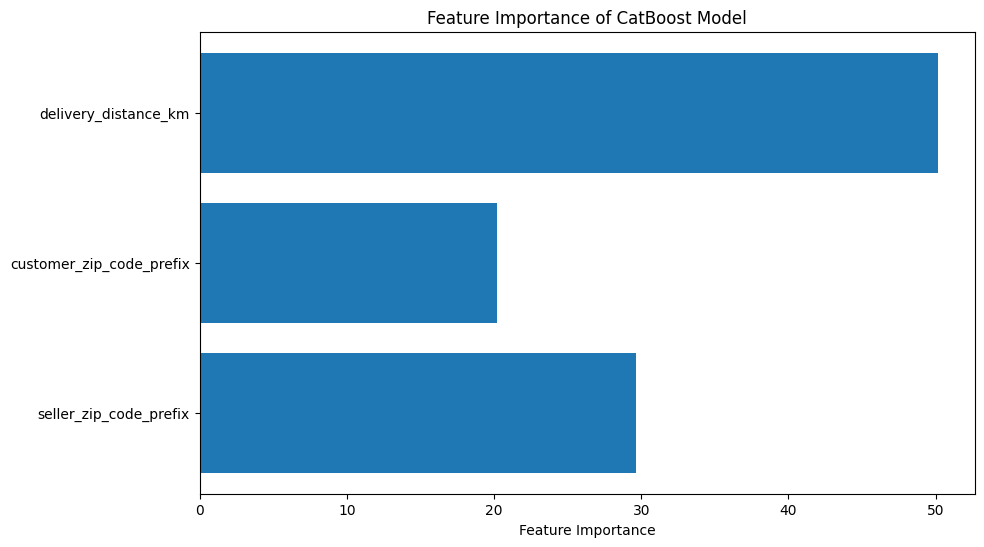

In [22]:
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Feature Importance of CatBoost Model')
plt.show()

In [15]:
model_path = '/srv/data/catboost_model.cbm'

if not os.path.exists(model_path):
    model.save_model(model_path)
    print('model saved')

loaded_model = CatBoostRegressor()
loaded_model.load_model(model_path)

model saved


In [23]:
df = filter_df_by_date(orders_dataset, dt_col='order_purchase_timestamp', date_filter={'start_date': '2017-02-01', 'end_date':'2017-12-01'})


In [24]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'purchase_dt'],
      dtype='object')

<Axes: >

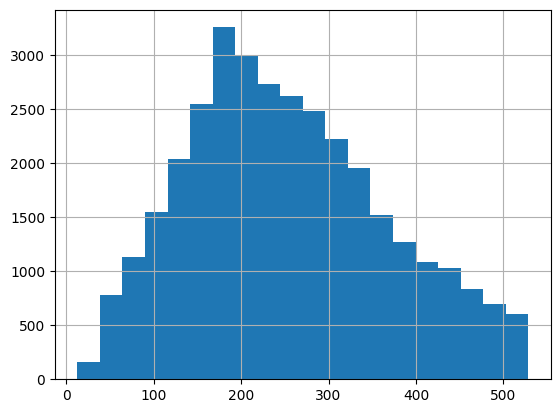

In [25]:
df = filter_df_by_date(orders_filtered_df, dt_col='order_purchase_timestamp', date_filter={'start_date': '2017-02-01', 'end_date':'2017-12-01'})

percentile_95 = df['delivery_time'].quantile(0.95)
df[df['delivery_time'] <= percentile_95]['delivery_time'].hist(bins=20)

In [26]:
orders_dataset['order_status'].value_counts(normalize=True)

order_status
delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: proportion, dtype: float64

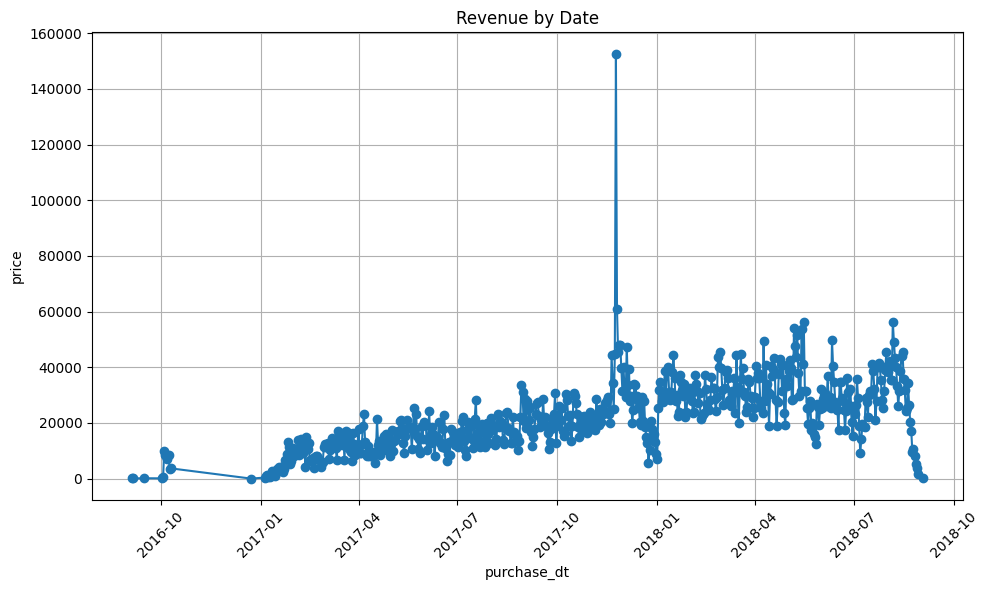

In [27]:

revenue_df = orders_items_dataset[['order_id', 'price']].merge(orders_dataset[['order_id', 'purchase_dt']], on='order_id')

plot_timeseries(revenue_df, 'price')

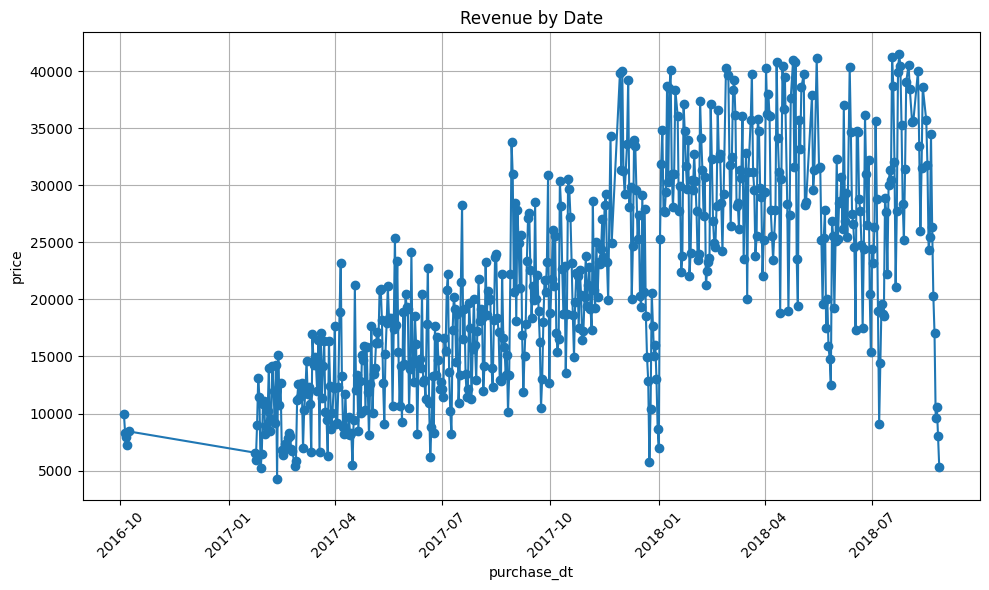

In [28]:
plot_timeseries(revenue_df, 'price', filter_outliers = True)

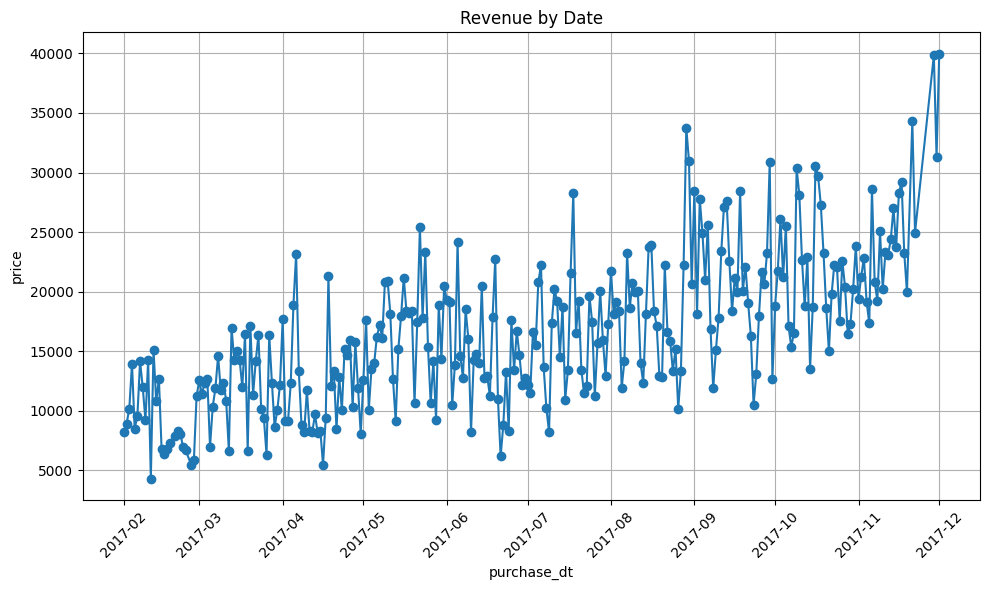

In [29]:
plot_timeseries(revenue_df, 'price', filter_outliers = True, date_filter={'start_date': '2017-02-01', 'end_date':'2017-12-01'})